# Data Prep

In [1]:
# Data Processing
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


#pano = pd.read_excel("C:\\Users\\vvelezpe\\OneDrive - Imperial College London\\Projects\\PANORAMA\\PANORAMA Data Summary.xlsx", sheet_name='Breath Only', index_col=0)
#pano.dropna(inplace=True, how='all')

#numeric_cols = pano.select_dtypes(include=np.number).columns

# Apply log1p to numeric columns
#pano[numeric_cols] = np.log1p(pano[numeric_cols])

#pano.to_csv("C:\\Users\\vvelezpe\\OneDrive - Imperial College London\\Projects\\PANORAMA\\PANORAMA Data Summary Breath Only log.csv")

cobra = pd.read_csv("C:\\Users\\vvelezpe\\OneDrive - Imperial College London\\Projects\\COBRA2\\COBRA Essential\\Compound Results Improved.csv", index_col=0)
cohort = pd.read_csv("C:\\Users\\vvelezpe\\OneDrive - Imperial College London\\Projects\\COBRA2\\COBRA Essential\\Test.csv", index_col=0)

In [2]:
cobra['cohort'] = cobra['site_patient'].map(cohort['Which cohort is the participant currently assigned to'])

In [3]:
cobra = cobra.dropna(subset=['cohort'])

In [4]:
cobra['cohort'].unique()

array(['Control group', 'Cancer group'], dtype=object)

In [5]:
meta = ['batch', 'num', 'tube', 'sample_type', 'Patient number', 'site_patient',
       'type', 'cohort']
#pano = pano[pano['Group'] != 'DN']
cobra['Cat'] = cobra["cohort"].apply(lambda x: 0 if x == "Control group" else 1)
dataset = cobra[cobra.columns.difference(meta)]

X = dataset.drop('Cat', axis=1)
y = dataset['Cat']

In [6]:
def _mfc_transform(X):
    ## LOG TRANSFORM AND MEDIAN FOLD CHANGE (Kiril Paper)

    ### Target Medians (per feature)
    # compute medians of non-zero values
    meds = X.apply(lambda x: np.median(x[x>0]), axis=0)

    ### Per Sample Scaling factor
    # For each sample, divide by the feature medians and take the median ratio
    nk = X.apply(lambda x: np.median(x/meds), axis=1)

    ### Normalise
    # Divide each row by its scaling factor
    norm = X.div(nk, axis=0)
    eps = np.median(norm.values[norm.values > 0])

    out = np.log(norm.abs() + eps) #norm and log transform

    return out

## Extract training set & perform feature selection


In [7]:
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold, SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix, classification_report, ConfusionMatrixDisplay
)
from scipy.stats import randint, uniform

RANDOM_STATE = 42

X_train, X_test, y_train, y_test = train_test_split(
                                    X, 
                                    y, 
                                    test_size=0.2, 
                                    stratify=y, 
                                    random_state=RANDOM_STATE)

# =========================================================
# Preprocessing
# =========================================================

# Imputation - Handle missing values
imputer = SimpleImputer(strategy="median")
X_train_imp = imputer.fit_transform(X_train)
X_test_imp  = imputer.transform(X_test)

# Log transform
X_train_log = np.log1p(X_train_imp)
X_test_log  = np.log1p(X_test_imp)

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_log)
X_test_scaled  = scaler.transform(X_test_log)

print("After preprocessing:", X_train_scaled.shape)

After preprocessing: (1152, 503)


In [8]:
# =========================================================
# Feature selection
# =========================================================

### Remove near-constant features
var_thresh = VarianceThreshold(threshold=0.0)
X_train_vt = var_thresh.fit_transform(X_train)
X_test_vt  = var_thresh.transform(X_test)

print("After variance threshold:", X_train_vt.shape)

## IMPROVE FEATURE SELECTION METHOD? BASED ON VOLATILITY AND VARIABILITY?
### Use RandomForest to rank features
rf_base = RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1)
rf_base.fit(X_train_vt, y_train)

# Select top 100 features
sfm = SelectFromModel(rf_base, max_features=200, threshold=-np.inf, prefit=True)
X_train_sel = sfm.transform(X_train_vt)
X_test_sel  = sfm.transform(X_test_vt)

print("After feature selection:", X_train_sel.shape)

After variance threshold: (1152, 503)
After feature selection: (1152, 200)


In [9]:
importances = rf_base.feature_importances_
# Create DataFrame
feature_importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': importances
})
# Sort by importance descending
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False).reset_index(drop=True)
feature_importance_df

,feature,importance
0,5.1313_Unknown_81,0.013329
1,7.0881_Methyl isobutyrate_71,0.010857
2,"7.466_Butanoic acid, methyl ester_74",0.008471
3,15.6607_Unknown_69,0.008254
4,5.0314_Ethanol_45,0.008098
...,...,...
498,25.6821_Hexacosane_57,0.000440
499,12.7042_Unknown_136,0.000408
500,28.7462_Hexacosane_57,0.000406
501,22.2677_Octacosane_57,0.000349


In [10]:
# =========================================================
# Evaluation function
# =========================================================
def evaluate_model(name, model, X_train, y_train, X_test, y_test):
    """Train, predict, evaluate, and return results as dict"""
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Some models have predict_proba, others decision_function
    try:
        y_prob = model.predict_proba(X_test)[:,1]
    except:
        try:
            from scipy.special import expit
            y_prob = expit(model.decision_function(X_test))
        except:
            y_prob = None
    
    results = {
        "model": name,
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred, zero_division=0),
        "recall": recall_score(y_test, y_pred, zero_division=0),
        "f1": f1_score(y_test, y_pred, zero_division=0),
        "roc_auc": roc_auc_score(y_test, y_prob) if y_prob is not None else np.nan
    }
    return results

results = []

## Random Forest

Ensemble method that combines predictions from various decision trees with varying hyperparameters.

**How it works**: ensemble of decision trees built on bootstrap samples; final prediction by majority vote (classification). Each tree splits on features to reduce impurity (Gini/entropy).

**When suited**: handles mixed scales, non-linear effects, interactions, robust to outliers and irrelevant features. Works well with many features (500).

**Pros**: little preprocessing, gives feature importances, handles nonlinearity, robust.

**Cons**: can overfit if not tuned, not as interpretable as simple linear models, may not provide well-calibrated probabilities out of the box.


Hyper-paramters:
- n_estimators: number of trees → more = lower variance, but slower. Usually hundreds are enough.
- max_depth: depth of trees → shallow trees → low variance, high bias; deep → high variance. Needs balancing.
- max_features: number of features tried per split → controls diversity of trees.
- class_weight: adjusts for class imbalance → prevents majority class dominance.

Random Forest accuracy: 0.7951388888888888
ROC-AUC: 0.9097110292424591


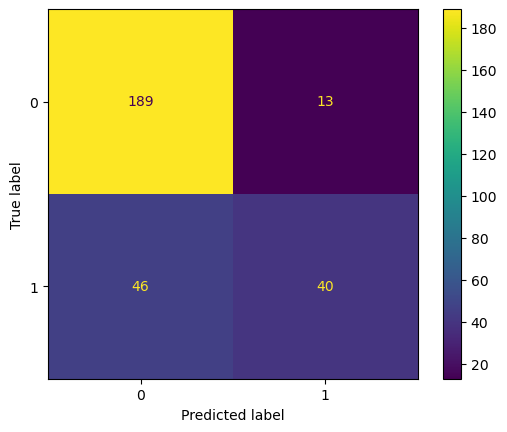

In [86]:
rf = RandomForestClassifier(
    n_estimators=500, # decision trees
    max_depth=None, # controls how deep trees grow
    random_state=RANDOM_STATE,
    max_features='log2', #features considered per split; sqrt is default for classification & log2 fractions (0.3,0.5) gives more diversity
    class_weight="balanced",
    n_jobs=-1)

rf.fit(X_train_sel, y_train)

y_pred = rf.predict(X_test_sel)
y_prob = rf.predict_proba(X_test_sel)[:,1]

print("Random Forest accuracy:", accuracy_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred)).plot()

In [9]:
# =========================================================
# Model optimization & evaluation
# =========================================================

# ----- Random Forest -----
param_dist = {
    "n_estimators": randint(100, 800),
    "max_depth": [None] + list(range(5, 51, 5)),
    "max_features": ["sqrt", "log2", 0.2, 0.5, 0.8],
    "class_weight": [None, "balanced"]
}
rf = RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1)
rf_search = RandomizedSearchCV(rf, param_distributions=param_dist, n_iter=30,
                               cv=StratifiedKFold(5), scoring="roc_auc",
                               random_state=RANDOM_STATE, n_jobs=-1)
results.append(evaluate_model("RandomForest", rf_search, X_train_sel, y_train, X_test_sel, y_test))

## Linear SVM

Uses a linear model to find a linear decision boundary (hyperplane) that best separates the data. The best hyperplane is the one that yields that largest separation/margin between both classes. Regularisation controls margin/complexity - is minimises to the loss function and maximises the distance between the decision boundary and the data points.

**When suited**: handles mixed scales, non-linear effects, interactions, robust to outliers and irrelevant features. Works well with many features (500).

**Pros**: little preprocessing, gives feature importances, handles nonlinearity, robust.

**Cons**: can overfit if not tuned, not as interpretable as simple linear models, may not provide well-calibrated probabilities out of the box.

Hyper-parameters:
- C (regularization strength):
    - Low C → wider margin, allows misclassifications (less variance, more bias).
    - High C → narrow margin, fits training data tightly (risk overfit).
    - Typical range: 1e-3 → 1e3 (logarithmic grid).

In [ ]:
lin_svm = SVC(
    kernel="linear",
    C=1.0,                   # regularization (higher = less regularization)
    class_weight="balanced",
    probability=True,        # enable predict_proba
    random_state=RANDOM_STATE
)
lin_svm.fit(X_train_vt, y_train)

y_pred = lin_svm.predict(X_test_vt)
y_prob = lin_svm.predict_proba(X_test_vt)[:,1]

print("Linear SVM accuracy:", accuracy_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred)).plot()

In [11]:
# =========================================================
# Model optimization & evaluation
# =========================================================

param_grid = {
    "C": [0.001,0.01, 0.1, 1, 10, 100],
    "class_weight": [None, "balanced"]
}
lin_svm = SVC(kernel="linear", probability=True, random_state=RANDOM_STATE)
lin_svm_search = GridSearchCV(lin_svm, param_grid, cv=StratifiedKFold(5), scoring="roc_auc", n_jobs=-1)
results.append(evaluate_model("LinearSVM", lin_svm_search, X_train_sel, y_train, X_test_sel, y_test))

## SVM

**How it works**: kernel SVM (e.g., RBF) maps features implicitly to a higher-dimensional space and finds a separating hyperplane.

**When suited**: when relationships are non-linear and data size is moderate. With 300 samples it’s feasible.

**Pros**: powerful non-linear decision boundaries, often strong performance for medium-sized datasets.

**Cons**: slower than linear SVMs for large feature sets, needs careful tuning of C and gamma, not inherently probabilistic (probability=True is expensive).

Hyperparameters:
- C (regularization strength):
    - Low C → wider margin, allows misclassifications (less variance, more bias).
    - High C → narrow margin, fits training data tightly (risk overfit).
    - Typical range: 1e-3 → 1e3 (logarithmic grid).
- gamma: controls kernel width.
    - Small γ = broad influence (decision boundary smooth).
    - Large γ = narrow influence (decision boundary bends tightly).

RBF SVM ROC-AUC: 0.6648629979276998


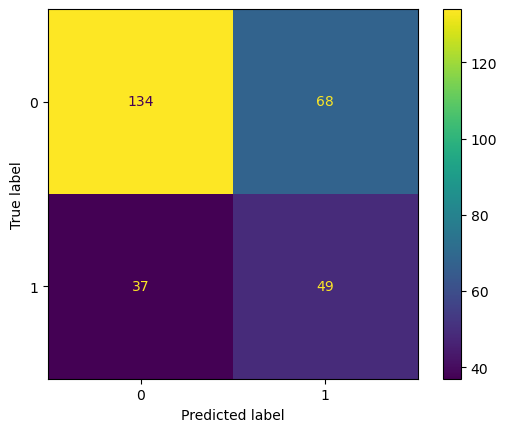

In [ ]:
rbf_svm = SVC(
    kernel="rbf",
    C=1.0,                   # controls margin
    gamma="scale",           # kernel width
    class_weight="balanced",
    probability=True,
    random_state=RANDOM_STATE
)
rbf_svm.fit(X_train_vt, y_train)

y_pred = rbf_svm.predict(X_test_vt)
y_prob = rbf_svm.predict_proba(X_test_vt)[:,1]

print("RBF SVM ROC-AUC:", roc_auc_score(y_test, y_prob))
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred)).plot()

In [13]:
# =========================================================
# Model optimization & evaluation
# =========================================================
param_grid = {
    "C": [0.001, 0.01, 0.1, 1, 10, 100],
    "gamma": ["scale", "auto", 0.01, 0.1, 1,10],
    "class_weight": [None, "balanced"]
}
rbf_svm = SVC(kernel="rbf", probability=True, random_state=RANDOM_STATE)
rbf_svm_search = GridSearchCV(rbf_svm, param_grid, cv=StratifiedKFold(5), scoring="roc_auc", n_jobs=-1)
results.append(evaluate_model("RBFSVM", rbf_svm_search, X_train_sel, y_train, X_test_sel, y_test))

## Logistic Regression

**How it works**: linear model modeling log-odds as linear function of features; outputs probabilities with sigmoid. Error is calculated with cross-entropy. L1 (Ridge) regularization penalizes the LLF with the scaled sum of the absolute values of the weights: |𝑏₀|+|𝑏₁|+⋯+|𝑏ᵣ|.

**When suited**: when relationship is (approximately) linear in features, and you want interpretable coefficients.

**Pros**: interpretable, fast, outputs probabilities, works well with regularization.

**Cons**: cannot capture non-linear relationships unless you add polynomial features or interactions.

Hyperparameter:
- C: represents the inverse of the regularisation strength
    - Smaller values increase regularisation (simpler models)
    - Larger values reduce it (complex models)

Logistic Regression ROC-AUC: 0.7552383145291274


c:\Users\vvelezpe\AppData\Local\miniconda3\envs\hanna\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


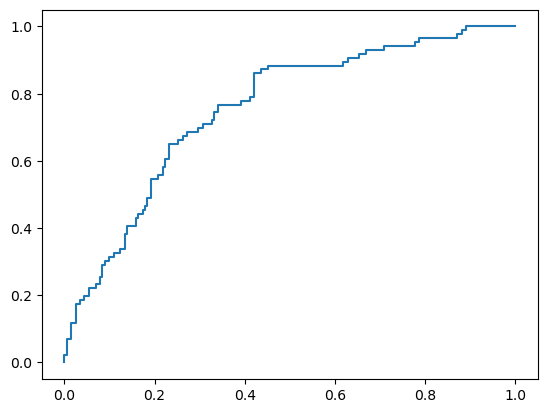

In [16]:
logreg = LogisticRegression(
    penalty="l2", ## ridge regularisation
    solver="saga",
    C=0.1,
    max_iter=5000,
    class_weight="balanced",
    random_state=RANDOM_STATE
)
logreg.fit(X_train_sel, y_train)

y_pred = logreg.predict(X_test_sel)
y_prob = logreg.predict_proba(X_test_sel)[:,1]

print("Logistic Regression ROC-AUC:", roc_auc_score(y_test, y_prob))
fpr, tpr, _ = roc_curve(y_test,  y_prob)
plt.plot(fpr,tpr)


In [ ]:
# =========================================================
# Model optimization & evaluation
# =========================================================

param_grid = {
    "C": [0.001, 0.01, 0.1, 1, 10, 100],
    "class_weight": [None, "balanced"],
    "solver": [None, "sag", "saga", "liblinear"]
}
logreg = LogisticRegression(penalty="l2", max_iter=5000, random_state=RANDOM_STATE)
logreg_search = GridSearchCV(logreg, param_grid, cv=StratifiedKFold(5), scoring="roc_auc", n_jobs=-1)
results.append(evaluate_model("LogisticRegression", logreg_search, X_train_sel, y_train, X_test_sel, y_test))


In [25]:
logreg_search

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=LogisticRegression(max_iter=5000, random_state=42),
             n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'class_weight': [None, 'balanced'],
                         'solver': [None, 'sag', 'saga', 'liblinear']},
             scoring='roc_auc')

## Lasso Logistic Regression

**How it works**: logistic regression with L1 penalty; shrinks many coefficients to zero → feature selection. L1 regularization (Lasso) penalizes the LLF with the scaled sum of the squares of the weights: 𝑏₀²+𝑏₁²+⋯+𝑏ᵣ².

**When suited**: when you suspect only a subset of compounds are informative; helpful with high-dimensional data.

**Pros**: automatic feature selection, simpler interpretable model.

**Cons**: when correlated features exist, L1 may arbitrarily choose one; may require tuning of C.

Number of non-zero features: 503
Logistic Regression ROC-AUC: 0.7665784020262492


c:\Users\vvelezpe\AppData\Local\miniconda3\envs\hanna\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


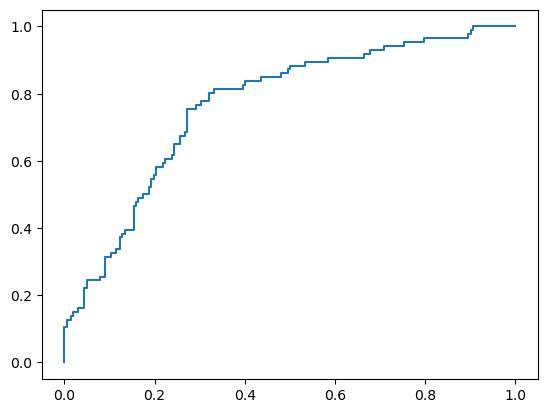

In [17]:
lasso = LogisticRegression(
    penalty="l1",
    solver="saga",
    C=0.5,                   # stronger penalty = more sparsity
    max_iter=5000,
    class_weight="balanced",
    random_state=RANDOM_STATE
)
lasso.fit(X_train_vt, y_train)

y_prob = lasso.predict_proba(X_test_vt)[:,1]

print("Number of non-zero features:", np.sum(lasso.coef_ != 0))

print("Logistic Regression ROC-AUC:", roc_auc_score(y_test, y_prob))
fpr, tpr, _ = roc_curve(y_test,  y_prob)
plt.plot(fpr,tpr)


In [17]:
# =========================================================
# Model optimization & evaluation
# =========================================================

# ----- Lasso Logistic Regression (L1) -----
param_grid = {
    "C": [0.01, 0.1, 1, 10, 100],
    "class_weight": [None, "balanced"],
    "solver": ["saga", "liblinear"]
}
lasso = LogisticRegression(penalty="l1", max_iter=4000, random_state=RANDOM_STATE)
lasso_search = GridSearchCV(lasso, param_grid, cv=StratifiedKFold(5), scoring="roc_auc", n_jobs=-1)
results.append(evaluate_model("LogisticLasso", lasso_search, X_train_sel, y_train, X_test_sel, y_test))

c:\Users\vvelezpe\AppData\Local\miniconda3\envs\hanna\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


## ElasticNet Logistic Regression

**How it works**: mixes L1 and L2 penalties (controlled by l1_ratio), combining sparsity and coefficient stability.

**When suited**: when features are correlated (common in omics) and you want both selection and stability.

**Pros**: handles correlated features better than L1 alone; flexible.

**Cons**: extra hyperparameter to tune; requires solver that supports elastic net (saga).

Logistic Regression ROC-AUC: 0.7640455906055722


c:\Users\vvelezpe\AppData\Local\miniconda3\envs\hanna\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


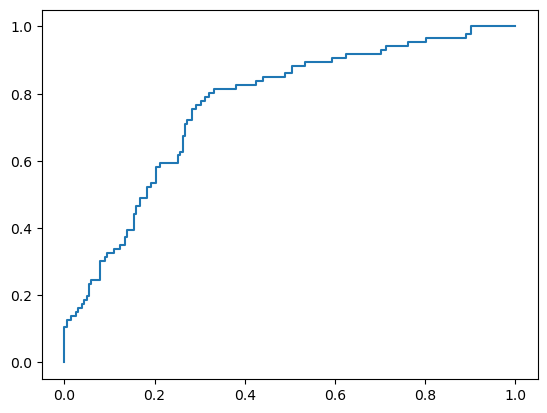

In [15]:
enet = LogisticRegression(
    penalty="elasticnet",
    solver="saga",
    C=0.01,
    l1_ratio=0.1,            # mix between L1 and L2
    max_iter=4000,
    class_weight="balanced",
    random_state=RANDOM_STATE
)
enet.fit(X_train_vt, y_train)
y_prob = enet.predict_proba(X_test_vt)[:,1]
print("Logistic Regression ROC-AUC:", roc_auc_score(y_test, y_prob))
fpr, tpr, _ = roc_curve(y_test,  y_prob)
plt.plot(fpr,tpr)


In [19]:
# =========================================================
# Model optimization & evaluation
# =========================================================

# ----- Elastic Net Logistic Regression -----
param_grid = {
    "C": [0.01, 0.1, 0.5, 1, 10, 100],
    "l1_ratio": [0.1, 0.5, 0.9, 1.0],
    "class_weight": [None, "balanced"],
    "solver": ["saga"]
}
enet = LogisticRegression(penalty="elasticnet", max_iter=5000, random_state=RANDOM_STATE)
enet_search = GridSearchCV(enet, param_grid, cv=StratifiedKFold(5), scoring="roc_auc", n_jobs=-1)
results.append(evaluate_model("LogisticElasticNet", enet_search, X_train_sel, y_train, X_test_sel, y_test))

c:\Users\vvelezpe\AppData\Local\miniconda3\envs\hanna\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [23]:
enet_search

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=LogisticRegression(max_iter=5000, penalty='elasticnet',
                                          random_state=42),
             n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 0.5, 1, 10, 100],
                         'class_weight': [None, 'balanced'],
                         'l1_ratio': [0.1, 0.5, 0.9, 1.0], 'solver': ['saga']},
             scoring='roc_auc')

## Model Evaluation
- Accuracy	
- Balanced accuracy	
- Precision	
- Recall	
- F1	
- ROC 
- AUC	
- Conf_True_Positive	
- Conf_False_Positive	
- Conf_False_Negative	
- Conf_True_Negative	
- N_Positive	
- N_Negative	
- N_total


In [22]:
results_df = pd.DataFrame(results)
results_df.sort_values("roc_auc", ascending=False)

,model,accuracy,precision,recall,f1,roc_auc
0,RandomForest,0.765957,0.736842,0.965517,0.835821,0.837165
1,LinearSVM,0.744681,0.840000,0.724138,0.777778,0.781609
4,LogisticLasso,0.829787,0.838710,0.896552,0.866667,0.779693
2,RBFSVM,0.744681,0.757576,0.862069,0.806452,0.741379
5,LogisticElasticNet,0.595745,0.678571,0.655172,0.666667,0.691571
3,LogisticRegression,0.638298,0.700000,0.724138,0.711864,0.687739


## Feature Selection

Stability analysis:
- Important features should reappear across folds or resamples
- Method:
    - Perform K-Fold CV
    - Record selected features in each fold (from Lasso/ElasticNet or RandomForest importances)
    - Compute selection frequency = proportion of folds a feature is chosen
- Features that consistently appear are more meaningful (less noise)

Possible Methods:
- Univariate filter (SelectKBest with f_classif)
    - Score each feature individually (ANOVA F-test).
    - Simple, interpretable, but ignores feature interactions.
- Recursive Feature Elimination (RFE)
    - Iteratively trains a model (e.g. Logistic/SVM) and removes least important features.
    - Computationally heavy, but gives ranked features.
- Regularization-based selection (Lasso, ElasticNet)
    - Shrinks coefficients; many become exactly 0.
    - Naturally integrated into modeling.
    - Works well for correlated predictors (ElasticNet preferred).
- RandomForest importance
    - Captures non-linearities and interactions.
    - Feature importances can be biased (favoring high-variance variables).

**To Implement**:
1. Use Lasso/ElasticNet for linear feature selection
2. Compare with RandomForest for non-linear selection
3. Track stability to see consistent signals

In [37]:
import numpy as np
import pandas as pd
from collections import defaultdict
import json

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from scipy.stats import randint

RANDOM_STATE = 42
N_FOLDS = 5
TEST_SIZE = 0.2

def preprocess(X_train, X_test):
    imputer = SimpleImputer(strategy="median")
    X_train_imp = imputer.fit_transform(X_train)
    X_test_imp = imputer.transform(X_test)

    # log-transform
    X_train_log = np.log1p(X_train_imp)
    X_test_log = np.log1p(X_test_imp)

    # scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_log)
    X_test_scaled = scaler.transform(X_test_log)

    return X_train_scaled, X_test_scaled

def select_features_rf(X_train, y_train, X_test, max_features=100):
    vt = VarianceThreshold(threshold=0.0)
    X_train_vt = vt.fit_transform(X_train)
    X_test_vt = vt.transform(X_test)

    rf = RandomForestClassifier(n_estimators=500, random_state=RANDOM_STATE, n_jobs=-1)
    rf.fit(X_train_vt, y_train)

    importances = rf.feature_importances_
    top_idx = np.argsort(importances)[::-1][:max_features]

    return X_train_vt[:, top_idx], X_test_vt[:, top_idx], vt.get_support(indices=True)[top_idx]

def evaluate_model(name, model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    try:
        y_prob = model.predict_proba(X_test)[:, 1]
    except:
        from scipy.special import expit
        y_prob = expit(model.decision_function(X_test))

    results = {
        "model": name,
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred, zero_division=0),
        "recall": recall_score(y_test, y_pred, zero_division=0),
        "f1": f1_score(y_test, y_pred, zero_division=0),
        "roc_auc": roc_auc_score(y_test, y_prob)
    }
    # Compute ROC curve points
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    results.update({
        "fpr": fpr,
        "tpr": tpr,
        "thresholds": thresholds
    })

    return results


def random_forest_model(cv=None):
    param_dist = {
        "n_estimators": randint(200, 800),
        "max_depth": [None] + list(range(5, 51, 5)),
        "max_features": ["sqrt", "log2", 0.3, 0.5, 0.8],
        "class_weight": [None, "balanced"]
    }
    rf = RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1)
    return RandomizedSearchCV(rf, param_distributions=param_dist, n_iter=30,
                              cv=cv, scoring="roc_auc", random_state=RANDOM_STATE, n_jobs=-1)

def linear_svm_model(cv=None):
    param_grid = {"C": [0.001, 0.01, 0.1, 1, 10, 100], "class_weight": [None, "balanced"]}
    svm = SVC(kernel="linear", probability=True, random_state=RANDOM_STATE)
    return GridSearchCV(svm, param_grid, cv=cv, scoring="roc_auc", n_jobs=-1)

def rbf_svm_model(cv=None):
    param_grid = {"C": [0.001, 0.01, 0.1, 1, 10, 100],
                  "gamma": ["scale", "auto", 0.01, 0.1, 1, 10],
                  "class_weight": [None, "balanced"]}
    svm = SVC(kernel="rbf", probability=True, random_state=RANDOM_STATE)
    return GridSearchCV(svm, param_grid, cv=cv, scoring="roc_auc", n_jobs=-1)

def logistic_l2_model(cv=None):
    param_grid = {"C": [0.001, 0.01, 0.1, 1, 10, 100], "class_weight": [None, "balanced"], "solver": ["sag", "saga", "liblinear"]}
    logreg = LogisticRegression(penalty="l2", max_iter=4000, random_state=RANDOM_STATE)
    return GridSearchCV(logreg, param_grid, cv=cv, scoring="roc_auc", n_jobs=-1)

def logistic_l1_model(cv=None):
    param_grid = {"C": [0.01, 0.1, 1, 10, 100], "class_weight": [None, "balanced"], "solver": ["saga", "liblinear"]}
    lasso = LogisticRegression(penalty="l1", max_iter=4000, random_state=RANDOM_STATE)
    return GridSearchCV(lasso, param_grid, cv=cv, scoring="roc_auc", n_jobs=-1)

def logistic_enet_model(cv=None):
    param_grid = {"C": [0.01, 0.1, 0.5, 1, 10, 100],
                  "l1_ratio": [0.1, 0.5, 0.9, 1.0],
                  "class_weight": [None, "balanced"],
                  "solver": ["saga"]}
    enet = LogisticRegression(penalty="elasticnet", max_iter=4000, random_state=RANDOM_STATE)
    return GridSearchCV(enet, param_grid, cv=cv, scoring="roc_auc", n_jobs=-1)

def feature_table(feature_importance_by_model, feature_names, N_FOLDS):
    importance_data = []

    for feat in feature_names:
        row = {"feature": feat}

        total_selections = 0
        scaled_importances = []

        # Process each model
        for model_name in ["RandomForest", "LogisticL1", "LogisticElasticNet"]:
            values = feature_importance_by_model[model_name].get(feat, [])

            if values:
                mean_importance = np.mean(values)
                selection_freq = len(values) / N_FOLDS
                row[f"{model_name}_mean_importance"] = mean_importance
                row[f"{model_name}_selection_freq"] = selection_freq

                total_selections += len(values)

                # Scale the importance for this feature relative to the max of this model group
                max_val = max(np.mean(v) for v in feature_importance_by_model[model_name].values()) if feature_importance_by_model[model_name] else 1.0
                scaled_importances.append(mean_importance / max_val if max_val > 0 else 0.0)
            else:
                row[f"{model_name}_mean_importance"] = 0.0
                row[f"{model_name}_selection_freq"] = 0.0
                scaled_importances.append(0.0)

        # Overall mean importance: average of scaled importances across groups
        row["overall_mean_importance"] = np.mean(scaled_importances)
        row["overall_selection_freq"] = total_selections / (N_FOLDS * 3)
        row["selected_by_n_models"] = sum(
            1 for model in ["RandomForest", "LogisticL1", "LogisticElasticNet"]
            if row[f"{model}_selection_freq"] > 0
        )

        importance_data.append(row)

    # Create enhanced feature importance DataFrame
    feature_importance_enhanced = pd.DataFrame(importance_data)
    feature_importance_enhanced.sort_values(
        ["overall_selection_freq", "overall_mean_importance"], 
        ascending=False, inplace=True
    )

    return feature_importance_enhanced



In [34]:
pano = pd.read_excel("C:\\Users\\vvelezpe\\OneDrive - Imperial College London\\Projects\\PANORAMA\\PANORAMA Data Summary.xlsx", sheet_name='Breath Only', index_col=0)
pano.dropna(inplace=True, how='all')

meta = ['F', 'Group', 'System']
pano = pano[pano['Group'] != 'DN']
pano['Cat'] = pano["Group"].apply(lambda x: 0 if x == "HV" else 1)
dataset = pano[pano.columns.difference(meta)]

X = dataset.drop('Cat', axis=1)
y = dataset['Cat']

#feature_names = [f"compound_{i}" for i in range(X.shape[1])]
feature_names = pano.columns.to_list()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

X_train_prep, X_test_prep = preprocess(X_train, X_test)
cv = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)


In [35]:
models = {
        "RandomForest": random_forest_model(cv=cv),
        "LinearSVM": linear_svm_model(cv=cv),
        "RBFSVM": rbf_svm_model(cv=cv),
        "LogisticL2": logistic_l2_model(cv=cv),
        "LogisticL1": logistic_l1_model(cv=cv),
        "LogisticElasticNet": logistic_enet_model(cv=cv)
    }

In [ ]:
results = []
#feature_importance_records = defaultdict(list)
feature_importance_by_model = {
"RandomForest": defaultdict(list),
"LogisticL1": defaultdict(list), 
"LogisticElasticNet": defaultdict(list)
}

best_params = {
"RandomForest": defaultdict(list),
"LogisticL1": defaultdict(list), 
"LogisticElasticNet": defaultdict(list)
}

for model_name in ["RandomForest", "LogisticL1", "LogisticElasticNet"]:
    #evaluate how consistently different features are selected/deemed important across multiple cross-validation folds for 3 different models

    # model loop
    print(f"Running stability analysis for {model_name}...")
    model = models[model_name]

    #for each model, cross-validation split on the training data. Each iteration creates different train/validation subsets
    for train_idx, val_idx in cv.split(X_train_prep, y_train):
        #data splitting
        X_tr, X_val = X_train_prep[train_idx], X_train_prep[val_idx]
        y_tr, y_val = y_train[train_idx], y_train[val_idx]
        model.fit(X_tr, y_tr)

        #gets the best model (for hyperparameter-tuned models that use GridSearchCV)
        best_model = model.best_estimator_ if hasattr(model, "best_estimator_") else model

        best_params[model_name] = {
        "best_score": float(model.best_score_) if hasattr(model, 'best_score_') else None,
        "best_params": model.best_params_ if hasattr(model, 'best_params_') else {},
        "model_params": best_model.get_params(),
        "model_type": type(best_model).__name__
        }
        ## Feature importance extraction
        if isinstance(best_model, RandomForestClassifier):
            #extracts random forest feature importances and records any non-zero values
            importances = best_model.feature_importances_
            for feat, imp in zip(feature_names, importances):
                if imp > 0:
                    feature_importance_by_model[model_name][feat].append(imp)

        elif isinstance(best_model, LogisticRegression) and best_model.penalty in ["l1", "elasticnet"]:
            #extracts absolute coefficient values and records any above a small threshold - wasn't negligible during regularisation
            coefs = np.abs(best_model.coef_).ravel()
            for feat, coef in zip(feature_names, coefs):
                if coef > 1e-6:
                    feature_importance_by_model[model_name][feat].append(coef)

In [ ]:
feature_stability = feature_table(feature_importance_by_model, feature_names, N_FOLDS=N_FOLDS)
feature_stability.to_csv("feature_stability_BA.csv", index=False)

In [21]:
top_features = feature_stability.sort_values(by='RandomForest_mean_importance', ascending=False).head(100)['feature'].tolist()

In [12]:
with open("best_params.json", "w") as f:
        json.dump(best_params, f, indent=4)

In [25]:
X_sel = X[top_features]

X_train_sel, X_test_sel, y_train_sel, y_test_sel = train_test_split(
    X_sel, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

X_train_sel, X_test_sel = preprocess(X_train_sel, X_test_sel)


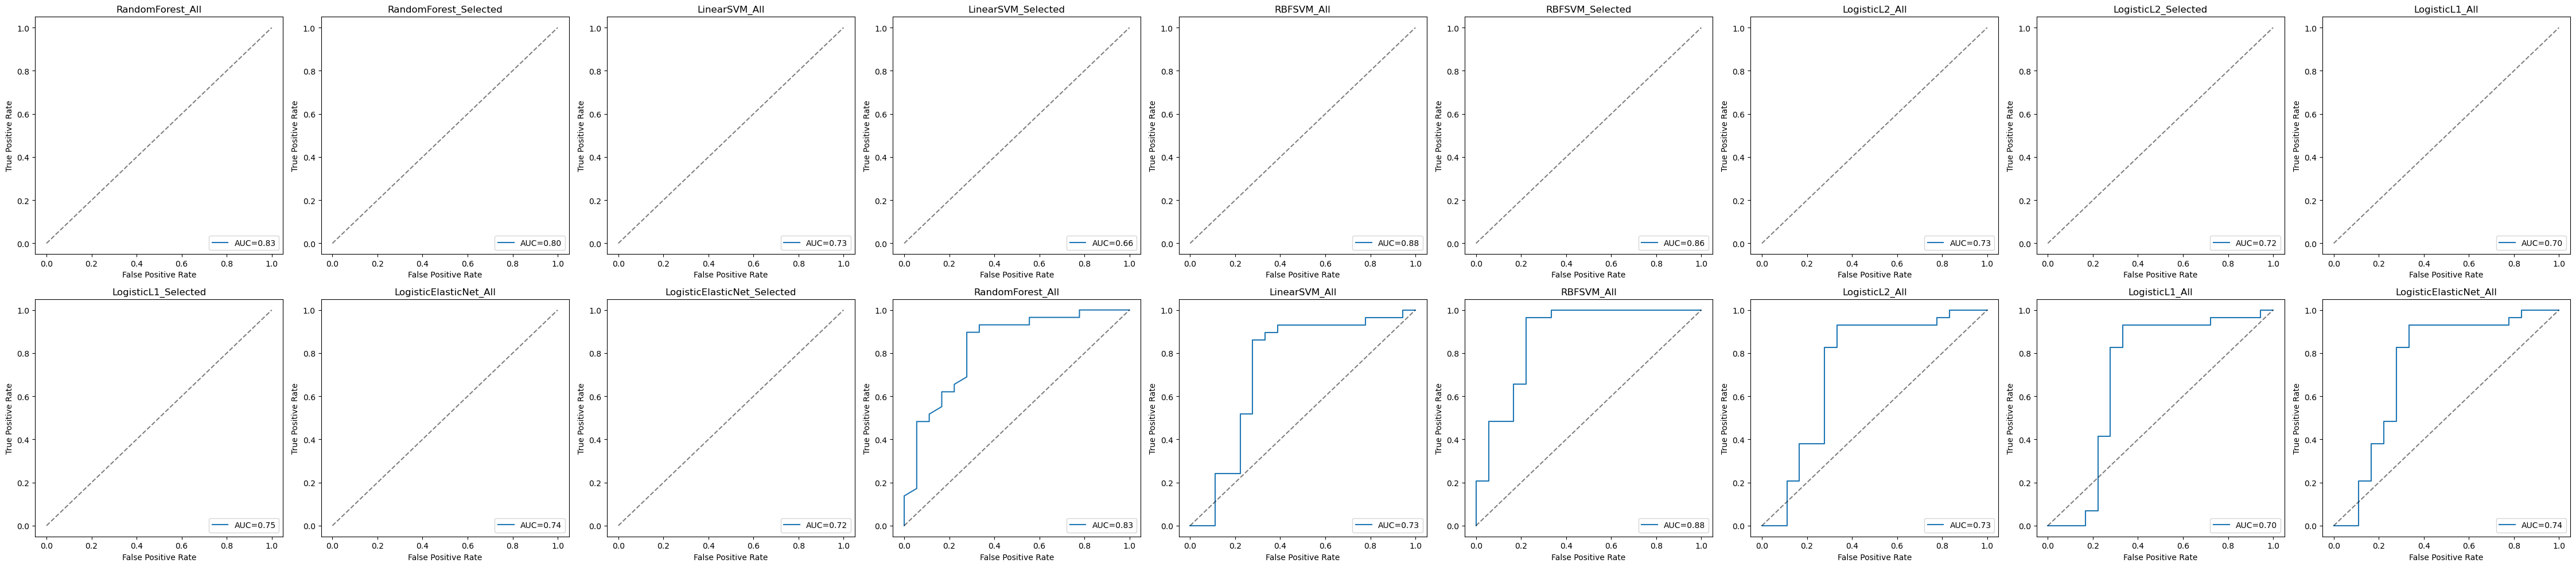

In [38]:
for name, model in models.items():
    res_all = evaluate_model(name + "_All", model, X_train_prep, y_train, X_test_prep, y_test)
    results.append(res_all)

    #res_sel = evaluate_model(name + "_Selected", model, X_train_sel, y_train_sel, X_test_sel, y_test_sel)
    #results.append(res_sel)
results_df = pd.DataFrame(results)
#results_df.to_csv("results_df.csv", index=False)

n_models = len(results_df)
n_rows = 2
n_cols = int(np.ceil(n_models / n_rows))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 5*n_rows))
axes = axes.flatten()  # Flatten in case of 2D array

for i, (_, row) in enumerate(results_df.iterrows()):
    ax = axes[i]
    fpr = row['fpr']
    tpr = row['tpr']
    auc = row['roc_auc']
    
    ax.plot(fpr, tpr, label=f"AUC={auc:.2f}")
    ax.plot([0,1], [0,1], 'k--', alpha=0.5)
    ax.set_title(row['model'])
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.legend(loc='lower right')

# Hide any unused subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [39]:
feature_stability.columns

Index(['feature', 'RandomForest_mean_importance',
       'RandomForest_selection_freq', 'LogisticL1_mean_importance',
       'LogisticL1_selection_freq', 'LogisticElasticNet_mean_importance',
       'LogisticElasticNet_selection_freq', 'overall_mean_importance',
       'overall_selection_freq', 'selected_by_n_models'],
      dtype='object')

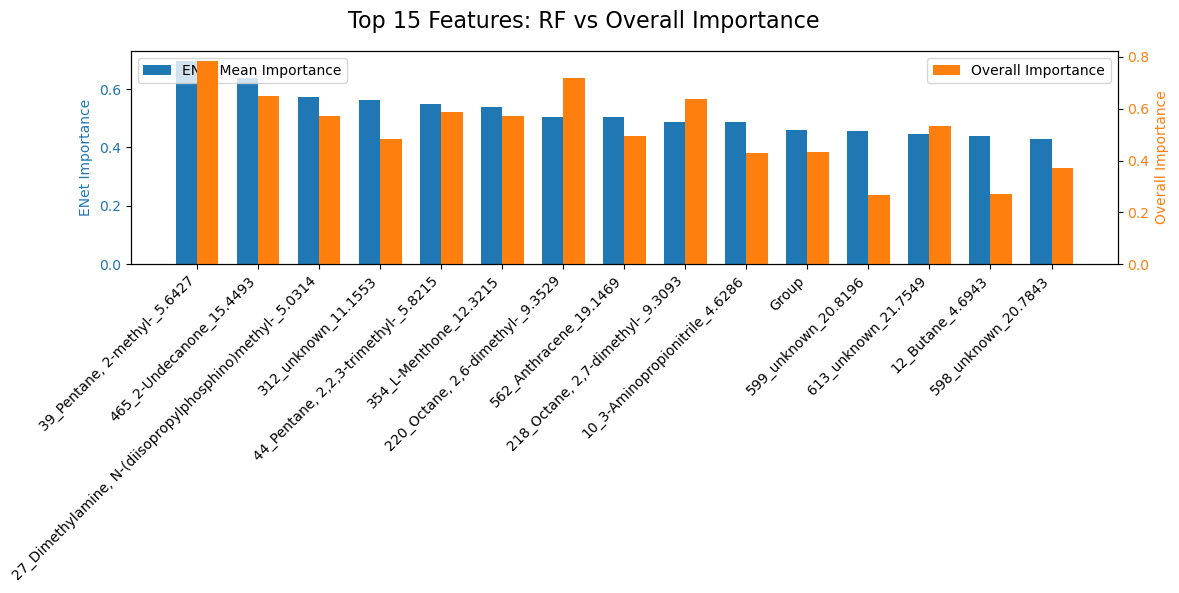

In [42]:
import matplotlib.pyplot as plt
import numpy as np

top_features = feature_stability.sort_values(
    'LogisticElasticNet_mean_importance', ascending=False
).head(15)

features = top_features['feature'].values
rf_importance = top_features['LogisticElasticNet_mean_importance'].values
overall_importance = top_features['overall_mean_importance'].values

x = np.arange(len(features))  # x positions
width = 0.35  # width of the bars

fig, ax1 = plt.subplots(figsize=(12,6))

# Bar for Random Forest importance (default blue)
bars1 = ax1.bar(x - width/2, rf_importance, width, label='ENet Mean Importance', color='C0')
ax1.set_ylabel('ENet Importance', color='C0')
ax1.tick_params(axis='y', labelcolor='C0')

# Secondary axis for overall importance (default orange)
ax2 = ax1.twinx()
bars2 = ax2.bar(x + width/2, overall_importance, width, label='Overall Importance', color='C1')
ax2.set_ylabel('Overall Importance', color='C1')
ax2.tick_params(axis='y', labelcolor='C1')

# X-axis labels
ax1.set_xticks(x)
ax1.set_xticklabels(features, rotation=45, ha='right')

# Title and legends
fig.suptitle('Top 15 Features: RF vs Overall Importance', fontsize=16)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()
